# 2020-04-17
## Segmenting nuclei from TF-MS2 lattice data

Picking up where the 2020-04-10 notebook left off, with segmented embryos. Going to try to segment nuclei from TF signal. Segmenting nuclei is likely important to avoid problems (artefacts), and the problem is a little different from what we normally do with histone channel. TF signal is non-uniform spatiallly and temporally (that's why it's interesting!). I'm going to start with the case of strong TF signal (bicoid anterior, dorsal in ventral regions, Zelda anywere).\

Strategy:

1. Start with a representative time point
2. Segment nuclei within that time point
3. Propagate to other times

Start with trying to segment a single 3D stack:

In [619]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
from skimage import filters, io
import skimage
from functools import partial
%matplotlib inline


In [2]:
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import read_tiff_folder, read_tiff_lattice, viewer, viewer, mask_plane, segment_embryo

In [3]:
#stack_e1m3 = read_tiff_lattice('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180215_BcdEve_em1_mv3', span=(36,40))
stack = read_tiff_lattice('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv1/', span=(30,40))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [6]:
## Color Pallettes
magenta = mpl.colors.LinearSegmentedColormap.from_list("", ["black","magenta"])
teal = mpl.colors.LinearSegmentedColormap.from_list("", ["black","aqua"])
green  = mpl.colors.LinearSegmentedColormap.from_list("", ["black","lime"])
blue = mpl.colors.LinearSegmentedColormap.from_list("", ["black","blue"])
purple = mpl.colors.LinearSegmentedColormap.from_list("", ["black","orchid"])
yellow = mpl.colors.LinearSegmentedColormap.from_list("", ["black","yellow"])



In [ ]:
# Useful code for timing operations

from timeit import timeit
setup = 'from __main__ import segment_embryo, stack; import numpy as np'
num=10
t1 = timeit('segment_embryo(stack)', setup=setup, number=num)

setup = 'from __main__ import segment_embryo2, stack; import numpy as np'
num=10
t2 = timeit('segment_embryo2(stack)', setup=setup, number=num)
#t1 = timeit('segment_embryo2(stack)', number=num)
#test2 = segment_embryo2(stack, )

In [ ]:
percentile = 95
t = np.percentile(img_smooth.flatten(), percentile);
mask = (np.where(img_smooth > t, ref, 0)).astype('bool')
mask = ndi.morphology.binary_erosion(mask, structure=np.ones((2,5,5)))
img_thresh = np.where(mask, ref, 0)
conn_comp, info = ndi.label(img_thresh.astype('bool'))
(labels, counts) = np.unique(conn_comp, return_counts=True)
upper_thresh=100000
lower_thresh=5000
labels_selected = labels[(counts >= lower_thresh) & (counts <= upper_thresh)]
print(labels_selected)
print(counts[labels_selected])
#viewer(conn_comp, 'zxy')
viewer(np.where(conn_comp in labels_selected, ref, 0), 'zxy')

## 2020-04-20

Tasks for today:
1. Settle on nucleus segmentation algorithm for single z stack
2. Propagate those assignments to other time points

### Segmenting nuclei in single 3D stack

In [4]:
def segment_nuclei_1(ref_stack, sigma=4, percentile=95, size_max=1e5, 
                     size_min=5000, erode_by=5):
    """Segment nuclei from a single 3D lattice stack.
    
    Details: Segments nuclei in lattice light sheet image substack. Uses
    gaussian smoothing and thresholding with a simple percentile to
    generate initial nuclear mask, then erodes this mask slightly, con-
    nects components, filters resulting objects for size, and returns
    a 3D labelmask of filtered structures.
    
    Optional: Input can be pre-segmented from background by segment_embryo
    function. This can help to standardize use of percentile-based 
    thresholding.
    
    Args:
        ref_stack: 3D ndarray
            Image stack in order [z, x, y]. This is a representative 
            substack (single channel and timepoint) of the full stack
            on which to perform segmentation.
        sigma: int
            Sigma value to use for gaussian smoothing
        percentile: int
            Percentile value to use for thresholding. Only non-zero pixels
            are used in calculating percentiles.
        size_max: int
            Upper size cutoff for connected structures (nuclei)
        size_min: int
            Lower size cutoff for connected structures
        erode_by: int
            Size of the structuring element (in x-y only) used to erode
            preliminary thresholded mask.
            
    Returns:
        labelmask: ndarray
            Same shape as input stack, filtered segmented structures are 
            masked by unique integer labels.
    """
    # Smooth input image.
    ref_smooth = ndi.filters.gaussian_filter(ref_stack, sigma=sigma)
    # Assign threshold value based on percentile of non-zero pixels, mask on threshold.
    t = np.percentile(ref_smooth[ref_smooth > 0], percentile);
    mask = np.where(ref_smooth > t, True, False)
    # Erode binary mask.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erode_by, erode_by)))
    # Label connected components to generate label mask.
    conn_comp, info = ndi.label(mask)
    # Filter labelmask based on maximum and minimum structure size.
    (labels, counts) = np.unique(conn_comp, return_counts=True)
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask = np.where(np.isin(conn_comp, labels_selected), conn_comp, 0)
    return labelmask


How to propagate to other frames with moving nuclei? I guess I could repeat the basic segmentation (smoothing and thresholding). I wonder if there's a better approach. It's quite difficult to google...

I kind of want to take advantage of the fact that I know where the nuclei are—a seed and extend approach. I'll try going through frame by frame, defining a 3D window around the centroid of the nucleus from the last frame, and re-thresholding inside that window.

I gave this a shot, and ended up with the following code. It's got some good ideas in it. I was trying to start with the first 3D stack segmentation and build frame by frame, using the centroids of segmented objects (nuclei) in the previous frame to seed a local segmentation approach. Unfortunately this is so far unstable, as I've tried several methods to do the local segmentation (based on intensities from previous frame segmentation) and it always grows or shrinks the objects, which makes some sense. I'm going to switch approaches but this code has some good in it and leaving it here.

In [5]:
from skimage.filters.thresholding import threshold_otsu, threshold_minimum, threshold_li

def make4Dmask_from3D(substack, labelmask, windowsize_ij=101, windowsize_z=45, sigma=4):
    """Propagate a 3D nucleus labelmask in time"""
    
    def threshold(stack, labelmask, nuc):
        # Get minimum and standard deviation of nucleus.
        vals = stack[labelmask == nuc]
        std = np.std(vals)
        min_ = np.mean(vals)
        print(min_)
        multiplier = 1
        # Set threshold to minimum minus a fraction of the stdev.
        return (min_ - (multiplier * std))
        '''
        bg_vals = stack[labelmask != nuc]
        t = bg_vals.max()
        print(t)
        return t
        '''
    
    def get_centroid(labelmask, id):
        coords = np.where(labelmask == id)
        # Find mean of each coordinate, remove negatives, make int.
        return [int(np.mean(x)) for x in coords]
    
    def segment_newframe(t, substack, labelmask_lastframe, windowsize_ij, windowsize_z):
        """Segment nuclei in 3D frame based on segmentation of previous frame"""
        # Make blank labelmask for this frame.
        substack_thisframe = substack[t]
        substack_lastframe = substack[t-1]
        labelmask_thisframe = np.zeros(labelmask_lastframe.shape)
        nuclei = np.unique(labelmask_lastframe)[1:] # skip background in 0 position
        for nuc in nuclei:
            # Find centroid of nucleus in last frame.
            (z, i, j) = get_centroid(labelmask_lastframe, nuc)
            # Define window around centroid.
            extend_z = int(windowsize_z / 2)
            extend_ij = int(windowsize_ij / 2)
            window_bounds = (
                z - extend_z,
                z + extend_z,
                i - extend_ij,
                i + extend_ij,
                j - extend_ij,
                j + extend_ij
            )
            (zmin, zmax, imin, imax, jmin, jmax) = [np.max([x, 0]) for x in window_bounds]
            #print((zmin, zmax, imin, imax, jmin, jmax))
            window_stack = substack_thisframe[zmin:zmax, imin:imax, jmin:jmax]
            window_old_labelmask = labelmask_lastframe[zmin:zmax, imin:imax, jmin:jmax]
            # Threshold using nucleus values from previous frame.
            t = threshold(substack_lastframe, labelmask_lastframe, nuc)
            window_mask = np.where(window_stack >= t, nuc, 0)
            window_new_labelmask, info = ndi.label(window_mask)
            # Get counts for overlap of new and old labels
            labels, counts = np.unique(window_new_labelmask[window_old_labelmask == nuc], return_counts=True)
            # Sort labels by counts (ascending).
            labels_sorted = labels[np.argsort(counts)]
            # Select new label with maximum overlap (provided it isn't 0)
            max_overlap = labels_sorted[-1]
            if (max_overlap == 0):
                max_overlap = labels_sorted[-2]            
            # Update segmentation in 4d labelmask.
            labelmask_thisframe[zmin:zmax, imin:imax, jmin:jmax][window_new_labelmask == max_overlap] = nuc
        
        return np.expand_dims(labelmask_thisframe, axis=0)
    
    # Smooth substack.
    print('Smoothing stack...')
    substack_smooth = ndi.filters.gaussian_filter(substack, sigma=sigma)
    #substack_smooth = np.copy(substack)
    # Make a copy of labelmask, add dimension at position 0.
    labelmask_4d = np.expand_dims(labelmask, axis=0) 
    print('Doin\' work')
    for t in range(1, substack.shape[0]):
        labelmask_4d = np.concatenate((labelmask_4d, segment_newframe(t, substack_smooth, labelmask_4d[t-1], windowsize_ij, windowsize_z)), axis=0)
    
    return labelmask_4d
#temp = make4Dmask_from3D(stack_t2[1], labelmask)
# DONT FORGET TO UNCOMMENT SMOOTH

OK trying a new strategy. I'm going to write three functions to do three things:
1. Segment nuclei in a 3D stack.
2. Update the labels in a segmented 3D stack to match labels from another stack (i.e., the previous frame, with maximum allowed movement parameters).
3. Wrapper to uses functions 1 and 2 to build a 4D segmented labelmask.

One advantage is that the wrapper will take functions as arguments, so I can swap in new functions (specifically for 1), experimenting with different ways to segment nuclei in 3D stacks and sorta plug and chug.

To start with, I'll just adapt the original thresholding-based segmentation algorithm to be the 3D segmentation function:

In [6]:
def segment_nuclei3D(stack, sigma=4, percentile=95, size_max=2e5, 
                     size_min=5000, erode_by=5):
    """Segment nuclei from a single 3D lattice stack.
    
    Details: Segments nuclei in lattice light sheet image substack. Uses
    gaussian smoothing and thresholding with a simple percentile to
    generate initial nuclear mask, then erodes this mask slightly, con-
    nects components, filters resulting objects for size, and returns
    a 3D labelmask of filtered structures.
    
    Optional: Input can be pre-segmented from background by segment_embryo
    function. This can help to standardize use of percentile-based 
    thresholding.
    
    Args:
        stack: 3D ndarray
            Image stack in order [z, x, y]. This is a representative 
            substack (single channel and timepoint) of the full stack
            on which to perform segmentation.
        sigma: int
            Sigma value to use for gaussian smoothing
        percentile: int
            Percentile value to use for thresholding. Only non-zero pixels
            are used in calculating percentiles.
        size_max: int
            Upper size cutoff for connected structures (nuclei)
        size_min: int
            Lower size cutoff for connected structures
        erode_by: int
            Size of the structuring element (in x-y only) used to erode
            preliminary thresholded mask.
            
    Returns:
        labelmask: ndarray
            Same shape as input stack, filtered segmented structures are 
            masked by unique integer labels.
    """
    # Smooth input image.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma)
    # Assign threshold value based on percentile of non-zero pixels, mask on threshold.
    t = np.percentile(stack_smooth[stack_smooth > 0], percentile);
    mask = np.where(stack_smooth > t, True, False)
    # Erode binary mask.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erode_by, erode_by)))
    # Label connected components to generate label mask.
    conn_comp, info = ndi.label(mask)
    # Filter labelmask based on maximum and minimum structure size.
    (labels, counts) = np.unique(conn_comp, return_counts=True)
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask = np.where(np.isin(conn_comp, labels_selected), conn_comp, 0)
    return labelmask

In [7]:
############################################################################
def update_labels(mask1, mask2):
    """Match labels of segmented structures to those of a previous frame.
    
    Uses a simple principle of reciprocal best hits: for each labeled object
    in mask 2, find the object in mask1 with the most overlapping pixels. 
    Then do the reverse: find the maximallly overlapping object in mask 1 for
    the objects in mask 2. For objects that are each other's best hit (most
    overlapping pixels), the labels in mask2 are replaced with those of mask1.
    Labels that do not have reciprocal best hits are dropped from the mask.
    
    Args:
        mask1: ndarray
            Labelmask in order [z, x, y]. Labels from this mask will be 
            propagated to mask2.
        mask2: ndarray
            Labelmask of same shape as mask1. Labels in this mask will be
            replaced by corresponding labels from mask1.
        
    Returns:
        updated_mask: ndarray
            Labelmask of identical shape to mask1 and mask2, updated to
            propagate labels from mask1 to mask2.
    
    Raises:
        ValueError:
            If the shapes of the two masks are not the same.
    """
    # Find the object in mask2 that has maximum overlap with an object in max1,
    # (as a fraction of the objects pixels in mask1)
    def get_max_overlap(mask1, mask2, label1):
        # Count overlapping pixels.
        labels, counts = np.unique(mask2[mask1 == label1], return_counts=True)
        # Sort labels by counts (ascending).
        labels_sorted = labels[np.argsort(counts)]
        # Select new label with maximum overlap.
        max_overlap = labels_sorted[-1]
        return max_overlap
    
    def main(mask1, mask2):
        if not (mask1.shape == mask2.shape):
            raise ValueError("Masks do not have the same shape.")
        # Initialize blank mask.
        updated_mask = np.zeros(mask2.shape)
        for label1 in np.unique(mask1):
            # Find label in mask2 with maximum overlap with nuc from mask1.
            label2 = get_max_overlap(mask1, mask2, label1)
            # Check that labels are "reciprocal best hits" by determining the 
            # label in mask1 with maximum overlap with label in mask2 found above.
            label2_besthit = get_max_overlap(mask2, mask1, label2)
            if ((label2_besthit == label1) and (label1 != 0)):
                updated_mask[mask2 == label2] = label1
        return updated_mask

    return main(mask1, mask2)
    

In [8]:
############################################################################
def segment_nuclei4D(stack, seg_func, update_func, **kwargs):
    """Segment nuclei in a 4D image stack (expect lattice data).
    
    A wrapper for two supplied functions: one function that performs
    segmentation of a 3D image stack and a second function that connects
    segmentation outputs for consecutive frames by identifying shared objects
    and harmonizing their labels. Iteratively calls these functions on all
    3D stacks and returns a 4D labelmask of segmented objects contiguous in 
    time.
    
    Args:
        stack: ndarray
            4D image stack of dimensions [t, z, x, y].
        seg_func: function
            Function that performs segmentation on 3D image stacks. Must take 
            as arguments a 3D image stack and optional keyword arguments.
        update_func: function
            Function that compares two 3D labelmasks, assigns object IDs from 
            mask1 to mask2, and updates labels in mask2 to match mask1.
        **kwargs: optional key-word arguments
            Keyword arguments to supply to segmentation function.
    
    Returns:
        labelmask: ndarray
            4D labelmask of dimensions [t, z, x, y] with segmented objects.
    
    Example usage:
        labelmask = segment_nuclei4D(im_stack, segment_nuclei3D, update_labels,
            sigma=5, percentile=90)
    """
    # Create partial form of segmentation function with supplied kwargs.
    seg_func_p = partial(seg_func, **kwargs)
    # Segment first frame, add 4th axis in 0 position.
    labelmask = seg_func_p(stack[0], **kwargs)
    labelmask = np.expand_dims(labelmask, axis=0) 
    
    # Segment subsequent frames, update labels, build 4D labelmask.
    for t in range(1, stack.shape[0]):
        mask = seg_func_p(stack[t], **kwargs)
        mask_updated = update_func(labelmask[t-1], mask)
        mask_updated = np.expand_dims(mask_updated, axis=0)
        labelmask = np.concatenate((labelmask, mask_updated), axis=0)
    
    return labelmask

def lattice_segment_nuclei_1(stack, channel=1, **kwargs):
    """Wrapper for nuclear segmentation routine for lattice data.
    
    Args:
        stack: ndarray
            5D image stack of dimensions [c, t, z, x, y].
        channel: int
            Channel (0th dimension) to use for segmentation.
        kwargs: key-word arguments (optional)
            Arguments for 3D segmentation function
        
    Returns:
        labelmask: ndarray
            4D labelmask of dimensions [t, z, x, y]
    
    
    """
    return segment_nuclei4D(stack[channel], segment_nuclei3D, update_labels, **kwargs)

This seems to be pretty effective for this stack. Now let's try it on a few different lattice stacks and see how it plays. I have three lattice stacks on this computer currently:

20171207_Zldeve_em1_mv1  
20180215_BcdEve_em1_mv2  
20180215_BcdEve_em1_mv3

In [9]:
file = '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20180215_BcdEve_em1_mv2/'
stack = read_tiff_lattice(file, span=(30,32))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [9]:
stack_emseg = segment_embryo(stack)

In [102]:
test = lattice_segment_nuclei_1(stack_emseg, 1, sigma=5, percentile=60)

In [105]:
#viewer(np.where(test, stack[1], 0))
#viewer(stack_emseg, 'ctzxy')
#viewer(stack[1], 'tzxy')

OK, I tried a bunch of settings and it's hard to get these weak bicoid nuclei to segment. The nice thing is, givent the modularity of these functions, I should only need to play with the 3D segmenting! Let's do that with a test stack. It's worth pointing out that this is probably a harder stack to segment, and making sure that this works on all data isn't necessarily critical. In fact, why don't I back up a second and test the existing routine on some more Zelda Data.

Added:  
20171207_Zldeve_em1_mv2  
20171207_Zldeve_em5_mv2

In [3]:
file = '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv2/'
stack = read_tiff_lattice(file, span=(30,32))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [9]:
stack_emseg = segment_embryo(stack)

In [11]:
test = lattice_segment_nuclei_1(stack_emseg, 1, sigma=4, percentile=85, 
                     size_max=5e5, size_min=2e4, erode_by=5)

In [12]:
viewer([np.where(test, stack[1], 0), stack[1]], 'tzxy')

interactive(children=(Dropdown(description='Color', index=2, options=('magma', 'Reds', 'viridis', 'inferno', '…

In [13]:
viewer(stack, 'ctzxy')

interactive(children=(Dropdown(description='Color', index=2, options=('magma', 'Reds', 'viridis', 'inferno', '…

In [11]:
def segment_nuclei3D(stack, sigma=4, percentile=95, size_max=2e5, 
                     size_min=5000, erode_by=5):
    """Segment nuclei from a single 3D lattice stack.
    
    Details: Segments nuclei in lattice light sheet image substack. Uses
    gaussian smoothing and thresholding with a simple percentile to
    generate initial nuclear mask, then erodes this mask slightly, con-
    nects components, filters resulting objects for size, and returns
    a 3D labelmask of filtered structures.
    
    Optional: Input can be pre-segmented from background by segment_embryo
    function. This can help to standardize use of percentile-based 
    thresholding.
    
    Args:
        stack: 3D ndarray
            Image stack in order [z, x, y]. This is a representative 
            substack (single channel and timepoint) of the full stack
            on which to perform segmentation.
        sigma: int
            Sigma value to use for gaussian smoothing
        percentile: int
            Percentile value to use for thresholding. Only non-zero pixels
            are used in calculating percentiles.
        size_max: int
            Upper size cutoff for connected structures (nuclei)
        size_min: int
            Lower size cutoff for connected structures
        erode_by: int
            Size of the structuring element (in x-y only) used to erode
            preliminary thresholded mask.
            
    Returns:
        labelmask: ndarray
            Same shape as input stack, filtered segmented structures are 
            masked by unique integer labels.
    """
    # Smooth input image.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma)
    # Assign threshold value based on percentile of non-zero pixels, mask on threshold.
    t = np.percentile(stack_smooth[stack_smooth > 0], percentile);
    mask = np.where(stack_smooth > t, True, False)
    # Erode binary mask.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erode_by, erode_by)))
    # Label connected components to generate label mask.
    conn_comp, info = ndi.label(mask)
    # Filter labelmask based on maximum and minimum structure size.
    (labels, counts) = np.unique(conn_comp, return_counts=True)
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask = np.where(np.isin(conn_comp, labels_selected), conn_comp, 0)
    return labelmask

I'm not sure how to show the data here, so I'll just record:

20171207_Zldeve_em1_mv: perfect  
20171207_Zldeve_em1_mv2: some problems. Hard to find a threshold that doesn't miss nuclei.

I'm going to try a new strategy. I think the edges of the nuclei (transitions from background) should be gettable. Going to try a general strategy:

1. Smooth
2. Do some kind of gradient filtering.
3. Close and fill (watershed?)
4. Filter for size and roundness.




In [14]:
segtest = stack_emseg[1,0]

I'm having trouble filling the circles. The sobel filter does a decent job of finding the nuclei so I can see them, but they end up with holes in the middle (expected) and I can't find a decent fill function in python.

Ah...there's this flood_fill function in ski. It fills all contiguous pixels that share the same value. So if I choose a 0 pixel in the "background", it will create a mask of the background. I can then use a distance mask to (maybe) get centers, or just use the inverse of this mask. Either way it's a good way to fill circles.

Function seems to work, but the circles aren't closed. Looking back at the Sobel results, the circles are there, we just need a more aggressive threshold. I tried the Li threshold, which seems to be more aggressive (lower threshold), and that seems better. 

In [140]:
from skimage.filters.thresholding import threshold_otsu, threshold_li
from skimage.transform import hough_ellipse
from skimage.feature import canny
# Working on seg function
# Gradient filters: sobel and prewitt
sigma=5
stack_smooth = ndi.filters.gaussian_filter(stack[1,0], sigma=sigma)

grad_z = ndi.filters.sobel(stack_smooth, axis=0)
grad_i = ndi.filters.sobel(stack_smooth, axis=1)
grad_j = ndi.filters.sobel(stack_smooth, axis=2)
grad = np.sqrt((grad_z ** 2) + (grad_i ** 2) + (grad_j ** 2))
grad3=grad
t1 = threshold_otsu(grad)
t2 = threshold_li(grad)
mask = np.where(grad >= t1, 1, 0)
mask2 = np.where(grad >= t2, 1, 0)
mask_blur = ndi.morphology.binary_dilation(mask, structure=np.ones((1,15,15)))
vmask1 = np.where(mask, 255, 0)
# Find centers for watershed
#mask_blur = ndi.morphology.binary_dilation(mask, structure=np.ones((1,10,10)))
mask_blur = ndi.morphology.binary_closing(mask, structure=np.ones((1,10,10)))
mask_blur = ndi.morphology.binary_closing(mask, structure=np.ones((1,10,10)))
mask_blur = ndi.morphology.binary_closing(mask, structure=np.ones((1,10,10)))
#mask_blur_dist = ndi.distance_transform_edt(mask_blur)
#mask_blur_dist = np.where(mask_blur, mask_blur_dist, 0)
vmask2 = np.where(mask_blur, 255, 0) #viewable mask
#dist = ndi.distance_transform_edt(mask)


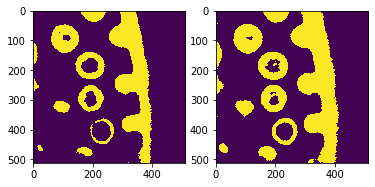

In [142]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask[20])
ax[1].imshow(mask2[20])

Great. Going to riff on this for a bit. Use more aggressive thresholding, flood-fill, to get background, and then see how a distance transform looks.

In [620]:
############################################################################

def imfill(mask, seed_pt='default'):
    '''Fill holes in a binary mask.
    
    Equivalent to matlab's imfill function, conceptually identical to fill
    functions in paint programs. seed_pt needs to be a point in the "back-
    ground" area to fill. All 0 or False pixels directly contiguous with the 
    seed are defined as background, all other pixels are declared foreground.
    Thus any "holes" (0 pixels that are not contiguous with background) are 
    filled in.
    
    Args:
        mask: ndarray
            Binary mask of n dimensions.
        seed_pt: tuple
            Pixel in mask to use for seeding "background". This is the equi-
            valent of the point you click when filling in paint.
    
    Returns:
        mask_filled: ndarray
            Binary mask filled    
    '''
    # By default, start in upper left corner.
    if (seed_pt == 'default'):
        seed_pt = tuple(np.zeros(mask.ndim).astype(int))
    # Fill all background pixels by changing them to 1. Changes are made to
    # original mask, so 1s are carried over in mask_flooded.
    mask_flooded = skimage.segmentation.flood_fill(mask, seed_pt,1)
    # Identify background pixels by those that are changed from original mask.
    # Unchanged pixels (0s and 1s) in original mask are now "filled" foreground.
    mask_filled = np.where(mask == mask_flooded, 1, 0)
    return mask_filled

In [285]:
# bg_mask = skimage.segmentation.flood_fill(mask, (0,0,511),1)
from skimage.filters.thresholding import threshold_li
from skimage.feature import peak_local_max
# Smooth stack.
sigma=5
stack_smooth = ndi.filters.gaussian_filter(stack[1,0], sigma=sigma)

# Take gradient separately for each dimension, combine as rootsumsquare.
grad_z = ndi.filters.sobel(stack_smooth, axis=0)
grad_i = ndi.filters.sobel(stack_smooth, axis=1)
grad_j = ndi.filters.sobel(stack_smooth, axis=2)
grad = np.sqrt((grad_z ** 2) + (grad_i ** 2) + (grad_j ** 2))

# Threshold.
t = threshold_li(grad)
mask = np.where(grad >= t, 1, 0)

# Use morphological processes to close.
mask = ndi.morphology.binary_closing(mask, structure=np.ones((1,8,8)))
# Fill in holes.
mask = imfill(mask)
# Do a distance transform, smooth, find peaks.
dist = ndi.distance_transform_edt(mask)
dist_sigma=2
dist = ndi.filters.gaussian_filter(dist, dist_sigma)
dist = dist.astype('uint8') # peak_local_max requires uint8
watershed_seeds = peak_local_max(dist, min_distance=20, indices=False)
print(len(np.where(watershed_seeds.flatten() == True)[0]))

5419


In [621]:
skimage.segmentation.flood_fill

<function skimage.morphology._flood_fill.flood_fill(image, seed_point, new_value, *, selem=None, connectivity=None, tolerance=None, inplace=False)>

I was trying to use distance transform of gradient to get seeds for watershed, but peak_local_max doesn't seem to work on 3D stacks. I had to write my own functions to do this. I use a max filter first, then select pixels whose value is equal to the local max. This produces clusters of contiguous points at the centers of nuclei. I then label these, take the centroid of each object, and those pixels are the local maxima peaks that I can use as watershed seeds.

In [387]:
############################################################################
def local_max(img, size=(70,100,100)):
    """Find local maxima pixels in an image stack within a given window.
    
    Defines local maxima as pixels whose value is equal to the maximum value
    within a defined window centered on that point. Implementation is to
    first run a maximum filter, then define pixels in the original image 
    whose value is equal to the max-filter result at the same positions as
    local maximum pixels. Returns a binary mask of such pixels.
    
    Args:
        img: ndarray
            Image stack
        size: tuple of ints
            Size of the window for finding local maxima. The sizes are the
            dimensions of the filter used to search for maxima. So a size
            of (100, 100) will use a square with side lengths of 100 pixels.
            Generally, you want the size dimensions to match the dimensions
            of the objects you're searching for.
    
    Returns:
        local_max: ndarray
            A binary mask with dimensions equal to img of pixels whose value 
            is equal to the local maximum value. 
    """
    # Apply a maximum filter.
    max_f = ndi.maximum_filter(img, size=size)
    # Find pixels that are local maxima.
    local_max = np.where(max_f == img, 1, 0)
    return(local_max)

In [430]:
############################################################################
def peak_local_max_nD(img, size=(70,100,100)):
    """Find local maxima in an N-dimensional image.
    
    Generalizes scikit's peak_local_max function to three (or more) 
    dimensions. Finds local maxima pixels within supplied window, determines
    centroids for connected pixels, and returns a mask of these centroid
    positions and a list of them.
    
    Suggested usage: finding seed points for watershed segmentation.
    
    Args:
        img: ndarray
            N-dimensional image stack
        size: tuple of ints
            Size of the window for finding local maxima. The sizes are the
            dimensions of the filter used to search for maxima. So a size
            of (100, 100) will use a square with side lengths of 100 pixels.
            Generally, you want the size dimensions to match the dimensions
            of the objects you're searching for.
    
    Returns:
        local_peak_mask: ndarray
            A labelmask with dimensions equal to img of single labeled 
            pixels representing local maxima.
        local_peaks: list of tuples
            Coordinates of pixels masked in local_peak_mask  
    """
    # Find pixels that represent local maxima. Produces clusters of connected
    # pixels at the centers of objects.
    maxes = local_max(img, size)
    # Connect these pixels in a labelmask.
    conn_comp, info = ndi.label(maxes)
    # Get the centroids of each local max object, update mask and list.
    local_peak_mask = np.zeros_like(img)
    local_peaks = []
    for id_ in np.unique(conn_comp)[1:]:
        centroid = get_object_centroid(conn_comp, id_)
        local_peak_mask[centroid] = id_
        local_peaks.append(centroid)
        
    return local_peak_mask, local_peaks

def get_object_centroid(labelmask, id):
    """Find the centroid of an object in a labelmask.
    
    Args:
        labelmask: ndarray
            Labelmask of arbitrary dimensions
        id: int
            Label of object to find centroid for
            
    Returns:
        centroid: tuple of ints
            Coordinates of the object's centroid
    """
    # Get coordinates 
    coords = np.where(labelmask == id)
    # Find mean of each coordinate, remove negatives, make int.
    return tuple([int(np.mean(x)) for x in coords])





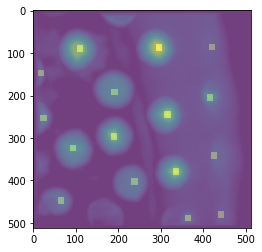

In [432]:
peaks, b = peak_local_max_nD(dist);
a = ndi.morphology.binary_dilation(peaks, structure=np.ones((3,15,15)))
plt.imshow(a.max(axis=0), alpha=0.5)
plt.imshow(dist.max(axis=0), alpha=0.5)

Pretty solid. OK, back to the issue at hand. I want to use these watershed seeds to perform watershed on the filled gradient image.

In [626]:
import skimage as ski
from skimage.filters.thresholding import threshold_li
from skimage.feature import peak_local_max
############################################################################
def segment_nuclei3D_2(stack, sigma=5, dist_sigma=2, window_size=(70, 100, 100),
                       closing_length=10, dilation_length = 3, size_max=2e5, size_min=5000, 
                       display=False):
    """Segment nuclei from a single 3D lattice stack.
    
    Details: Segments nuclei in lattice light sheet 3D image substack. Uses
    a gradient filter to find edges of nuclei, fills them, finds their 
    centers, and performs watershed segmentation. Resulting objects are 
    filtered for size and roundness and a 3D labelmask of nuclei is returned.
    
    Args:
        stack: 3D ndarray
            Image stack in order [z, x, y].
        sigma: int
            Sigma value to use for gaussian smoothing of original image.
        dist_sigma: int
            Sigma value to use for gaussian smoothing of distance transform
            of gradient.
        closing_length: int
            Side length of the structuring unit for morphological closing of 
            thresholded gradient mask.
        dilation_length: int
            Side length of the structuring unit for morphological dilation of 
            final mask.
        window_size: tuple of ints
            Size of the window for finding local maxima to seed watershed. 
            The sizes are the dimensions of the filter used to search for 
            maxima. So a size of (100, 100) will use a square with side lengths 
            of 100 pixels. Generally, you want the size dimensions to match 
            the dimensions of the objects you're searching for.
        size_max: int
            Maximum size in pixels allowed for segmented nuclei.
        size_min: int
            Minimum size in pixels allowed for segmented nuclei.
        display: bool
            If true, displays segmentation intermediates.
            
    Returns:
        labelmask: ndarray
            Same shape as input stack, filtered segmented structures are 
            masked by unique integer labels.
    """
    # Smooth stack.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma)

    # Take gradient separately for each dimension, combine as rootsumsquare to 
    # approximate 3D gradient.
    grad_z = ndi.filters.sobel(stack_smooth, axis=0)
    grad_i = ndi.filters.sobel(stack_smooth, axis=1)
    grad_j = ndi.filters.sobel(stack_smooth, axis=2)
    grad = np.sqrt((grad_z ** 2) + (grad_i ** 2) + (grad_j ** 2))

    # Threshold.
    t = threshold_li(grad)
    mask = np.where(grad >= t, 1, 0)

    # Close with morphological filter.
    mask = ndi.morphology.binary_closing(mask, structure=np.ones((1, closing_length, closing_length)))
    
    # Fill in holes.
    mask = imfill(mask)
    
    # Do a distance transform, smooth, find peaks.
    dist = ndi.distance_transform_edt(mask)
    dist = ndi.filters.gaussian_filter(dist, dist_sigma)
    seed_mask, seeds = peak_local_max_nD(dist, window_size)
    
    # Subtract mean background from gradient image.
    grad_mean = grad.mean()
    grad_bgsub = np.where(grad >= grad_mean, grad, 1)
    # Perform watershed segmentation on subtracted gradient with seeds.
    ws = ski.segmentation.watershed(grad_bgsub, seed_mask.astype(int))
   
    # Filter segmented objects for maximum and minimum size.
    (labels, counts) = np.unique(ws, return_counts=True)
    labels_selected = labels[(counts >= size_min) & (counts <= size_max)]
    labelmask = np.where(np.isin(ws, labels_selected), ws, 0)
    
    # Close and slightly dilate resulting mask, re-label.
    labelmask = ndi.morphology.binary_closing(labelmask, structure=np.ones((1, closing_length, closing_length)))
    labelmask = ndi.morphology.binary_dilation(labelmask, structure=np.ones((1, dilation_length, dilation_length)))
    labelmask, info = ndi.label(labelmask)
    
    # Display segmentation intermediates if called.
    if (display):
        fig, ax = plt.subplots(2,3, figsize=(9,9))
        ax[0][0].set_title('Smoothed input')
        ax[0][0].imshow(stack_smooth.max(axis=0))
        ax[0][1].set_title('Gradient')
        ax[0][1].imshow(grad.max(axis=0))
        ax[0][2].set_title('Dist. trnsfm')
        ax[0][2].imshow(dist.max(axis=0))
        ax[1][0].set_title('Watershed seeds')
        # Dilate seed mask to make single pixels visible.
        seed_mask_visible = ndi.morphology.binary_dilation(seed_mask, structure=np.ones((3,15,15)))
        ax[1][0].imshow(dist.max(axis=0), alpha=0.5)
        ax[1][0].imshow(seed_mask_visible.max(axis=0), alpha=0.5)
        ax[1][1].set_title('Gradient bgsub')
        ax[1][1].imshow(grad_bgsub.max(axis=0))
        ax[1][2].set_title('Seg final')
        ax[1][2].imshow(labelmask.max(axis=0))
        plt.tight_layout()
        
    return labelmask


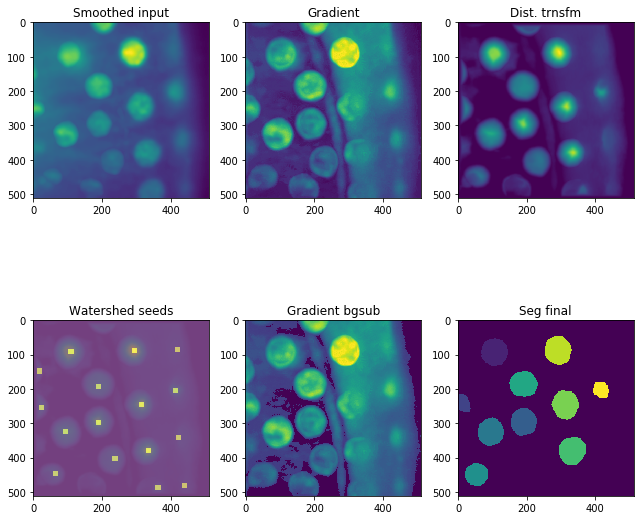

In [627]:
import skimage as ski
#c7, g7 = segment_nuclei3D_2(stack, sigma=7)
c5t = segment_nuclei3D_2(stack[1,0], sigma=5, display=True)

#dist.dtype

In [630]:
viewer([stack[1,0], c5t*30], 'zxy')

interactive(children=(Dropdown(description='Color', index=7, options=('Greens', 'prism', 'Reds', 'plasma', 'ma…

This seems pretty good. I'm going to move to a new notebook and test this out on several stacks.